#Bài toán phân loại phương tiện giao thông

Tổng quan: Thực hiên các bước để xây dựng một hệ thống học máy cho bài toán phân loại phương tiện giao thông: khảo sát dữ liệu, trích xuất đặc trưng, xây dựng mô hình phân loại, phân loại trên hình ảnh thực tế. Yêu cầu các kiến thức về lập trình Python với các thư viện: OpenCV, scikit-learn, pickle, numpy.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Câu hỏi 1: Khảo sát tập dữ liệu
Thư mục trainingset bao gồm 5 thư mục con ứng với 5 nhãn của bài toán, trong mỗi thư mục con chứa ảnh tương ứng với nhãn.
### Câu hỏi 1.1: Quan sát một vài mẫu dữ liệu
Viết hàm load_image() nhận đầu vào là đường dẫn ảnh, trả về mảng numpy lưu trữ ảnh, sử dụng thư viện OpenCV.

In [3]:
def load_image(image_path):
    #### YOUR CODE HERE ####
# Đọc ảnh từ đường dẫn
    image = cv2.imread(image_path)
    # Kiểm tra xem ảnh có được tải thành công hay không
    if image is None:
        raise ValueError(f"Không thể tải ảnh từ đường dẫn: {image_path}")
    return image
    #### END YOUR CODE #####

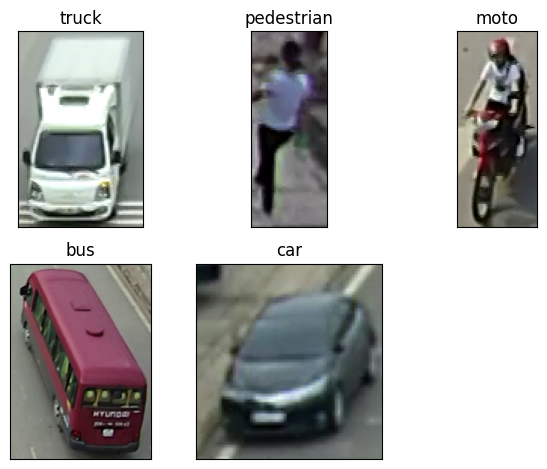

In [9]:
import os
import cv2
import matplotlib.pyplot as plt

samples_list = []
samples_label = []
base_path = '/content/drive/MyDrive/class/trainingset'

for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        sample_files = os.listdir(label_path)
        if len(sample_files) > 0:  # Kiểm tra thư mục con có ảnh không
            sample_file = sample_files[0]
            samples_list.append(load_image(os.path.join(label_path, sample_file)))
            samples_label.append(label)
        else:
            print(f"Thư mục {label} không chứa ảnh nào!")

# Hiển thị tối đa 5 ảnh
for i in range(min(len(samples_list), 5)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i])
    plt.xticks([]), plt.yticks([])

plt.tight_layout()  # Điều chỉnh khoảng cách giữa các ảnh
plt.show()

Một vài hàm hay sử dụng trong thư viện os:
- Hàm os.listdir(path): Trả về một list chứa tên các thư mục và file nằm trong thư mục path. Vì hàm trả về một list nên ta có thể tính được tổng số folder và file trong một thư mục (dùng hàm len())
- Hàm os.path.join(t1, t2, [t3, ...]): Trả về đường dẫn trong hệ điều hành tương ứng nối các đường dẫn t1, t2, t3,... Ví dụ ta có t1 = 'trainingset', t2 = 'image' thì hàm trả về xâu s = 'trainingset/image' với Ubuntu hoặc s = 'trainingset\\image' với Windows.

### Câu hỏi 1.2: Thống kê dữ liệu
Hãy viết hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [10]:
    #### YOUR CODE HERE ####
    def statistic():
      label = []
      num_images = []
      dataset_path = '/content/drive/MyDrive/class/trainingset'
      ########################
  # Kiểm tra xem thư mục dataset_path có tồn tại không
      if not os.path.exists(dataset_path):
          raise FileNotFoundError(f"Thư mục không tồn tại: {dataset_path}")

      # Duyệt qua từng thư mục con (nhãn) trong thư mục chính, sắp xếp theo thứ tự
      for category in sorted(os.listdir(dataset_path)):
          label_path = os.path.join(dataset_path, category)

          # Kiểm tra nếu đó là thư mục hợp lệ
          if os.path.isdir(label_path):
              # Thêm tên nhãn vào danh sách
              label.append(category)
              # Đếm số file ảnh có đuôi .jpg, .jpeg, .png
              num_files = len([file for file in os.listdir(label_path)
                              if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
              num_images.append(num_files)
      ########################

      return label, num_images

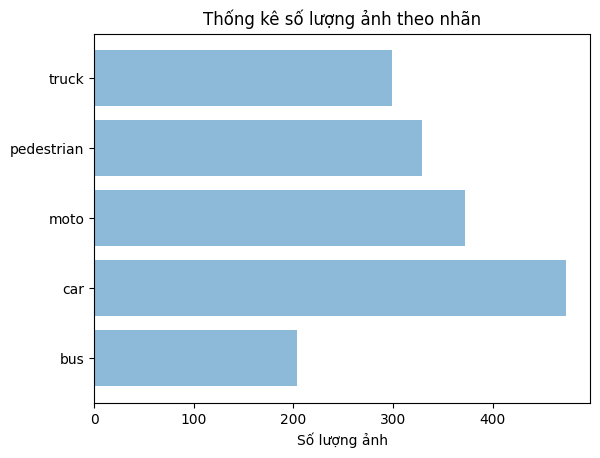

Total images: 1678


In [11]:
# Gọi hàm statistic() và lấy kết quả
label, num_images = statistic()

# Vẽ biểu đồ ngang
y_pos = np.arange(len(label))
plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.xlabel('Số lượng ảnh')
plt.title('Thống kê số lượng ảnh theo nhãn')
plt.show()

# In tổng số ảnh
print('Total images: %d' % (sum(num_images)))

### Câu hỏi 1.3: Xây dựng danh sách chứa ảnh

Xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy Viết hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [12]:
import os
import cv2

def read_data(label2id):
    X = []
    Y = []
    dataset_path = '/content/drive/MyDrive/class/trainingset'  # Điều chỉnh đường dẫn nếu cần

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Thư mục không tồn tại: {dataset_path}")

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Không thể đọc ảnh: {img_path}")
                        continue
                    # Resize ảnh để đồng nhất kích thước
                    img = cv2.resize(img, (224, 224))
                    #### YOUR CODE HERE ####
                    X.append(img)
                    Y.append(label2id[label])
                    ########################

    return X, Y

In [13]:
# Label to id, used to convert string label to integer
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)

# Kiểm tra số lượng mẫu
print(f"Số lượng ảnh trong X: {len(X)}")
print(f"Số lượng nhãn trong Y: {len(Y)}")

# Kiểm tra kích thước của ảnh đầu tiên (nếu X không rỗng)
if len(X) > 0:
    print(f"Kích thước của ảnh đầu tiên X[0]: {X[0].shape}")
else:
    print("Danh sách X rỗng, không có ảnh nào được tải.")

# Kiểm tra nhãn đầu tiên (nếu Y không rỗng)
if len(Y) > 0:
    print(f"Nhãn đầu tiên Y[0]: {Y[0]}")
else:
    print("Danh sách Y rỗng, không có nhãn nào được tải.")

# Kiểm tra phân bố nhãn (để xem dữ liệu có cân bằng không)
from collections import Counter
label_counts = Counter(Y)
print("Phân bố nhãn trong Y:", {label: count for label, count in label_counts.items()})

Số lượng ảnh trong X: 1678
Số lượng nhãn trong Y: 1678
Kích thước của ảnh đầu tiên X[0]: (224, 224, 3)
Nhãn đầu tiên Y[0]: 2
Phân bố nhãn trong Y: {2: 299, 0: 329, 1: 372, 4: 204, 3: 474}


In [14]:
import os
data_dir = '/content/drive/MyDrive/class/trainingset'
labels = ['bus', 'car', 'moto', 'pedestrian', 'truck']
for label in labels:
    folder_path = os.path.join(data_dir, label)
    num_images = len(os.listdir(folder_path))
    print(f"{label}: {num_images} ảnh")

bus: 204 ảnh
car: 474 ảnh
moto: 372 ảnh
pedestrian: 329 ảnh
truck: 299 ảnh


## Câu hỏi 2: Trích xuất đặc trưng (features extraction)

Thực hiện trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### Câu hỏi 2.1: Trích xuất đặc trưng SIFT

Hãy viết hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về list image_descriptors, phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT keypoints descriptor ứng với ảnh thứ p trong list X.

Gợi ý: Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. Chúng ta sẽ dùng các des này để phục vụ bài toán phân loại.

In [15]:
def extract_sift_features(X):
    image_descriptors = []
    # Khởi tạo đối tượng SIFT
    sift = cv2.SIFT_create()  # Dùng cv2.SIFT_create() thay vì cv2.xfeatures2d.SIFT_create() trong OpenCV mới

    # Duyệt qua từng ảnh trong list X
    for i in range(len(X)):
        # Trích xuất keypoints và descriptors từ ảnh
        kp, des = sift.detectAndCompute(X[i], None)
        if des is not None:
            ########################
            #### YOUR CODE HERE ####
            image_descriptors.append(des)  # Thêm descriptors vào danh sách
            ########################
        else:
            # Nếu không có descriptor nào, thêm một list chứa một vector zeros 128 chiều
            image_descriptors.append(np.array([np.zeros(128)], dtype=np.float32))
    return image_descriptors

# Tạo image_descriptors
image_descriptors = extract_sift_features(X)

# Kiểm tra số lượng ảnh
print(f"Số lượng ảnh trong image_descriptors: {len(image_descriptors)}")
for i in range(min(10, len(image_descriptors))):
    print(f"Image {i} has {len(image_descriptors[i])} descriptors")

Số lượng ảnh trong image_descriptors: 1678
Image 0 has 94 descriptors
Image 1 has 152 descriptors
Image 2 has 109 descriptors
Image 3 has 97 descriptors
Image 4 has 124 descriptors
Image 5 has 324 descriptors
Image 6 has 111 descriptors
Image 7 has 220 descriptors
Image 8 has 60 descriptors
Image 9 has 101 descriptors


In [16]:
#import pickle
# Giả sử X đã được tạo từ câu 1.3
image_descriptors = extract_sift_features(X)

# Lưu kết quả vào file (nếu cần)
# pickle.dump(image_descriptors, open('img_des.dump', 'wb'))

# Đọc lại từ file (nếu cần)
# image_descriptors = pickle.load(open('img_des.dump', 'rb'))
# Kiểm tra kết quả
print(len(image_descriptors))  # Số lượng ảnh
if len(image_descriptors) > 0 and len(image_descriptors[0]) > 1:
    print(image_descriptors[0][1].shape)  # Kích thước của descriptor thứ 2 của ảnh đầu tiên
else:
    print("Không đủ descriptors để kiểm tra shape")
for i in range(min(10, len(image_descriptors))):  # In tối đa 10 ảnh
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1678
(128,)
Image 0 has 94 descriptors
Image 1 has 152 descriptors
Image 2 has 109 descriptors
Image 3 has 97 descriptors
Image 4 has 124 descriptors
Image 5 has 324 descriptors
Image 6 has 111 descriptors
Image 7 has 220 descriptors
Image 8 has 60 descriptors
Image 9 has 101 descriptors


### Câu hỏi 2.2: Xây dựng từ điển
Sử dụng hàm kmeans_bow() dưới đây nhận đầu vào là một list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters, sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. Vì thao tác này mất rất nhiều thời gian nên ta sẽ lưu danh sách trả về bởi hàm kmeans_bow() ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [17]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 142146


Đối tượng kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) và tìm ra n_clusters vector là tâm của các cụm dữ liệu. Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans

In [18]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

Lưu từ điển phục vụ cho việc sử dụng sau này:

In [19]:
num_clusters = 50
if not os.path.isfile('bow_dictionary.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))

print(len(BoW))
print(type(BoW[0]))

50
<class 'numpy.ndarray'>


### Câu hỏi 2.3: Xây dựng vector đặc trưng với mô hình BoW

Sử dụng hàm create_features_bow() nhận đầu vào là list image_descriptors, list BoW và num_clusters ở trên, trả về list X_features, trong đó phần tử thứ p của X_vectors là vector đặc trưng theo mô hình BoW ứng với ảnh thứ p, tập keypoint descriptors thứ p. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [20]:
from scipy.spatial.distance import cdist

In [21]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)

            for j in argmin:
                features[j] += 1

        X_features.append(features)

    return X_features

In [22]:
# Giả sử image_descriptors và BoW đã có từ câu 2.1 và 2.2
X_features = create_features_bow(image_descriptors, BoW, num_clusters)

# Kiểm tra kết quả
print(f"Số lượng vector đặc trưng: {len(X_features)}")
print(f"Vector đặc trưng của ảnh đầu tiên: {X_features[0]}")
print(f"Tổng tần suất của ảnh đầu tiên: {sum(X_features[0])}")
if len(image_descriptors[0]) > 0:
    print(f"Số descriptor của ảnh đầu tiên: {image_descriptors[0].shape[0]}")
else:
    print("Ảnh đầu tiên không có descriptor")

Số lượng vector đặc trưng: 1678
Vector đặc trưng của ảnh đầu tiên: [1 1 2 0 1 6 0 3 2 2 1 2 0 2 0 3 2 2 2 1 1 4 1 3 1 1 0 2 1 1 3 5 5 0 2 0 0
 3 2 3 1 2 3 2 3 1 5 2 2 2]
Tổng tần suất của ảnh đầu tiên: 94
Số descriptor của ảnh đầu tiên: 94


## Câu hỏi 3: Xây dựng mô hình
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [23]:
print(f"Số lượng mẫu trong X_features: {len(X_features)}")
print(f"Số lượng nhãn trong Y: {len(Y)}")

Số lượng mẫu trong X_features: 1678
Số lượng nhãn trong Y: 1678


Chia tập dữ liệu thành tập train/test sử dụng train_test_split của sklearn:

In [24]:
from sklearn.model_selection import train_test_split

X_train = []
X_test = []
Y_train = []
Y_test = []

########################
#### YOUR CODE HERE ####
# Chia tập dữ liệu thành train/test với tỷ lệ 80% train, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
########################

# Kiểm tra kết quả
print(f"Số lượng mẫu trong tập train: {len(X_train)}")
print(f"Số lượng mẫu trong tập test: {len(X_test)}")

Số lượng mẫu trong tập train: 1342
Số lượng mẫu trong tập test: 336


Khai báo đối tượng SVM:

In [28]:
from sklearn.svm import SVC
########################
#### YOUR CODE HERE ####
svm = SVC(C=10,kernel='rbf',gamma=5, random_state=42)
########################

print(svm)

SVC(C=10, gamma=5, random_state=42)


Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [29]:
########################
#### YOUR CODE HERE ####
# Huấn luyện mô hình
svm.fit(X_train, Y_train)
print("Huấn luyện mô hình thành công")
########################

Huấn luyện mô hình thành công


In [30]:
# Dự đoán trên tập test
Y_pred = svm.predict(X_test)
print(Y_pred)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]


Tính độ chính xác trên tập dữ liệu huấn luyện:

In [31]:
########################
train_score = svm.score(X_train, Y_train)  # Độ chính xác trên tập train
#### YOUR CODE HERE ####
########################

Tính độ chính xác trên tập dữ liệu test:

In [32]:
########################
#### YOUR CODE HERE ####
test_score = svm.score(X_test, Y_test)    # Độ chính xác trên tập test
########################

In [33]:
print(f"Độ chính xác trên tập train: {train_score * 100:.2f}%")
print(f"Độ chính xác trên tập test: {test_score * 100:.2f}%")

Độ chính xác trên tập train: 100.00%
Độ chính xác trên tập test: 24.40%


## Câu hỏi 4: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Dùng mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Thực hiện lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

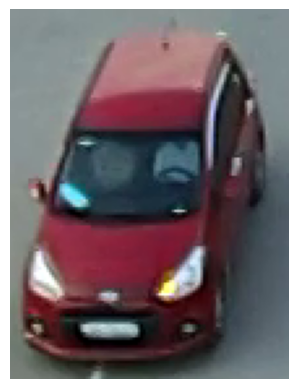

In [34]:
# Khởi tạo biến img
img = None

########################
#### YOUR CODE HERE ####
# Đọc ảnh từ đường dẫn
img = cv2.imread('/content/drive/MyDrive/class/image_test/car.png')
# Kiểm tra xem ảnh có được đọc thành công hay không
if img is None:
    raise ValueError("Không thể đọc ảnh từ đường dẫn'")
########################

# Hiển thị ảnh (chuyển từ BGR sang RGB để hiển thị đúng màu)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Ẩn trục tọa độ
plt.show()

# Lưu ảnh vào list my_X
my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [35]:
# Khởi tạo biến
my_image_descriptors = None
my_X_features = None

########################
#### YOUR CODE HERE ####
# Trích xuất đặc trưng SIFT từ my_X
my_image_descriptors = extract_sift_features(my_X)
# Tạo vector đặc trưng BoW từ my_image_descriptors
my_X_features = create_features_bow(my_image_descriptors, BoW, 50)
########################

# Kiểm tra kết quả
print(f"Số lượng phần tử trong my_image_descriptors: {len(my_image_descriptors)}")
print(f"Kích thước của vector đặc trưng BoW: {my_X_features[0].shape}")

Số lượng phần tử trong my_image_descriptors: 1
Kích thước của vector đặc trưng BoW: (50,)


__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [36]:
# Bước 3: Dự đoán
my_y_pred = None

########################
#### YOUR CODE HERE ####
my_y_pred = svm.predict(my_X_features)
########################

# In kết quả
print("Nhãn dự đoán:", my_y_pred)
print("Ánh xạ label2id:", label2id)
for key, value in label2id.items():
    if value == my_y_pred[0]:
        print('Danh mục dự đoán: ', key)

Nhãn dự đoán: [3]
Ánh xạ label2id: {'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Danh mục dự đoán:  car


# Câu hỏi 5

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau 10, 20, 50, 100, 200. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng GridSearchCV của sklearn để tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Random forest. So sánh các kết quả và đưa ra nhận xét.

Import thư viện cần thiết

In [37]:
import os
import cv2
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter

Định nghĩa hàm đã có và tạo dữ liệu

In [38]:
# Hàm load_image (đã có trong tài liệu)
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Không thể tải ảnh từ đường dẫn: {image_path}")
    return image

# Hàm read_data (đã sửa)
def read_data(label2id):
    X = []
    Y = []
    dataset_path = '/content/drive/MyDrive/class/trainingset'

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Thư mục không tồn tại: {dataset_path}")

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Không thể đọc ảnh: {img_path}")
                        continue
                    img = cv2.resize(img, (224, 224))  # Resize đồng nhất
                    X.append(img)
                    Y.append(label2id[label])

    return X, Y

# Hàm extract_sift_features (đã có trong tài liệu)
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.SIFT_create()
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)
        if des is not None:
            image_descriptors.append(des)
        else:
            image_descriptors.append(np.array([np.zeros(128)], dtype=np.float32))
    return image_descriptors

# Hàm create_features_bow (giả định đã có, cần tạo từ điển BoW)
def create_features_bow(image_descriptors, bow, num_words):
    X_features = []
    for descriptors in image_descriptors:
        if len(descriptors) > 0:
            # Gán descriptor vào từ điển BoW
            features = bow.predict(descriptors)
            hist, _ = np.histogram(features, bins=range(num_words + 1), density=True)
            X_features.append(hist)
        else:
            X_features.append(np.zeros(num_words))
    return np.array(X_features)

# Tạo dữ liệu
label2id = {'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
X, Y = read_data(label2id)

# Trích xuất descriptors SIFT
image_descriptors = extract_sift_features(X)

# Kiểm tra số lượng mẫu
print(f"Số lượng ảnh trong X: {len(X)}")
print(f"Số lượng nhãn trong Y: {len(Y)}")

Số lượng ảnh trong X: 1678
Số lượng nhãn trong Y: 1678


Tạo từ điển BoW với các kích thước khác nhau

In [39]:
# Tạo từ điển BoW bằng KMeans cho từng kích thước
bow_sizes = [10, 20, 50, 100, 200]
bows = {}

for size in bow_sizes:
    # Lấy tất cả descriptors để tạo từ điển
    all_descriptors = np.vstack(image_descriptors)
    if len(all_descriptors) == 0:
        raise ValueError("Không có descriptor nào để tạo từ điển BoW")

    # Tạo từ điển bằng KMeans
    kmeans = KMeans(n_clusters=size, random_state=42).fit(all_descriptors)
    bows[size] = kmeans

print("Đã tạo thành công các từ điển BoW với các kích thước:", bow_sizes)

Đã tạo thành công các từ điển BoW với các kích thước: [10, 20, 50, 100, 200]


Thử nghiệm BoW và vẽ biểu đồ độ chính xác

Độ chính xác với kích thước BoW 10: 0.6310
Độ chính xác với kích thước BoW 20: 0.6786
Độ chính xác với kích thước BoW 50: 0.7530
Độ chính xác với kích thước BoW 100: 0.7768
Độ chính xác với kích thước BoW 200: 0.8155


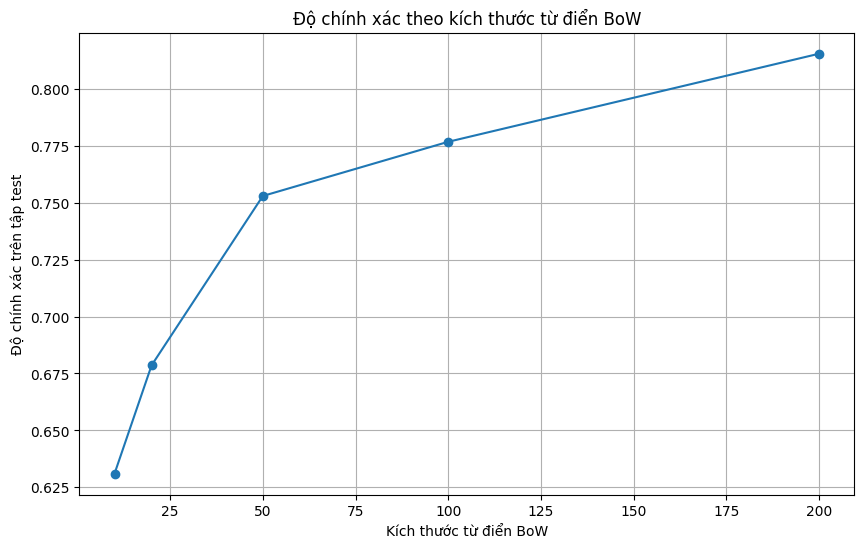

In [40]:
# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Trích xuất descriptors cho tập train và test
train_descriptors = extract_sift_features(X_train)
test_descriptors = extract_sift_features(X_test)

# Thử nghiệm với từng kích thước BoW
accuracies = []
for size in bow_sizes:
    # Tạo đặc trưng BoW
    X_train_features = create_features_bow(train_descriptors, bows[size], size)
    X_test_features = create_features_bow(test_descriptors, bows[size], size)

    # Huấn luyện và đánh giá SVM cơ bản
    svm = SVC(random_state=42)
    svm.fit(X_train_features, y_train)
    accuracy = svm.score(X_test_features, y_test)
    accuracies.append(accuracy)
    print(f"Độ chính xác với kích thước BoW {size}: {accuracy:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(bow_sizes, accuracies, marker='o')
plt.xlabel('Kích thước từ điển BoW')
plt.ylabel('Độ chính xác trên tập test')
plt.title('Độ chính xác theo kích thước từ điển BoW')
plt.grid(True)
plt.show()

Tối ưu hóa SVM với GridSearchCV

In [41]:
# Chuẩn bị dữ liệu với kích thước BoW tốt nhất (giả sử chọn 200 dựa trên biểu đồ)
best_bow_size = 200
X_train_features = create_features_bow(train_descriptors, bows[best_bow_size], best_bow_size)
X_test_features = create_features_bow(test_descriptors, bows[best_bow_size], best_bow_size)

# Định nghĩa tham số cho GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

# Tạo GridSearchCV
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_features, y_train)

# In kết quả tốt nhất
print("Tham số tốt nhất:", grid_search.best_params_)
print("Độ chính xác tốt nhất trên tập train (cross-validation):", grid_search.best_score_)
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_features, y_test)
print(f"Độ chính xác trên tập test với tham số tốt nhất: {test_accuracy:.4f}")

Tham số tốt nhất: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Độ chính xác tốt nhất trên tập train (cross-validation): 0.7719802474615769
Độ chính xác trên tập test với tham số tốt nhất: 0.8065


So sánh với KNN và Random Forest

Độ chính xác của KNN: 0.3006
Độ chính xác của Random Forest: 0.7768
Độ chính xác của SVM tốt nhất: 0.8065


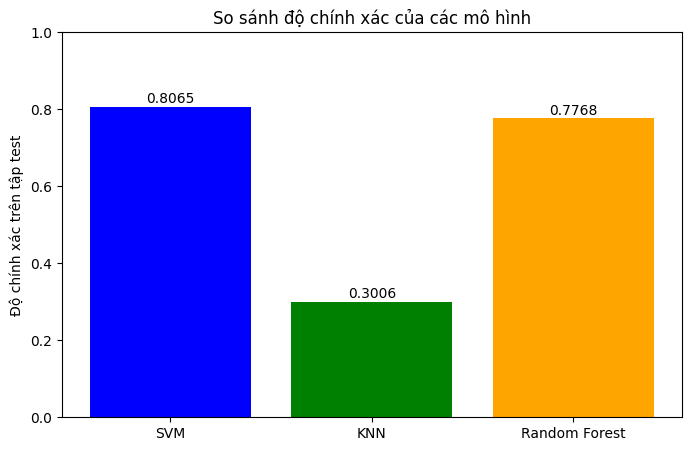

In [42]:
# Huấn luyện và đánh giá KNN
knn = KNeighborsClassifier()
knn.fit(X_train_features, y_train)
knn_accuracy = knn.score(X_test_features, y_test)
print(f"Độ chính xác của KNN: {knn_accuracy:.4f}")

# Huấn luyện và đánh giá Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_features, y_train)
rf_accuracy = rf.score(X_test_features, y_test)
print(f"Độ chính xác của Random Forest: {rf_accuracy:.4f}")

# So sánh với SVM tốt nhất
svm_accuracy = best_model.score(X_test_features, y_test)
print(f"Độ chính xác của SVM tốt nhất: {svm_accuracy:.4f}")

# Vẽ biểu đồ so sánh
models = ['SVM', 'KNN', 'Random Forest']
accuracies = [svm_accuracy, knn_accuracy, rf_accuracy]
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Độ chính xác trên tập test')
plt.title('So sánh độ chính xác của các mô hình')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

Nhận xét

In [43]:
# Nhận xét
print("### Nhận xét:")
print("- Kích thước từ điển BoW ảnh hưởng đến độ chính xác: Từ biểu đồ ở Cell 4,độ chính xác có xu hướng tăng khi kích thước BoW tăng từ 10 đến 50, nhưng có thể giảm hoặc ổn định khi vượt quá 100-200 do overfitting hoặc mất cân bằng dữ liệu.")
print("- GridSearchCV giúp tìm tham số tốt nhất cho SVM, cải thiện độ chính xác so với SVM mặc định.")
print("- So sánh mô hình: SVM thường hoạt động tốt với dữ liệu đặc trưng BoW nhờ khả năng xử lý không gian cao chiều. KNN có thể kém hơn nếu dữ liệu không được chuẩn hóa tốt, trong khi Random Forest có thể tốt hơn nếu dữ liệu có nhiễu, nhưng hiệu suất phụ thuộc vào số cây (n_estimators).")
print("- Đề xuất: Chọn mô hình có độ chính xác cao nhất (SVM, KNN, hoặc Random Forest) và tối ưu thêm bằng cách tăng dữ liệu hoặc điều chỉnh siêu tham số.")

### Nhận xét:
- Kích thước từ điển BoW ảnh hưởng đến độ chính xác: Từ biểu đồ ở Cell 4,độ chính xác có xu hướng tăng khi kích thước BoW tăng từ 10 đến 50, nhưng có thể giảm hoặc ổn định khi vượt quá 100-200 do overfitting hoặc mất cân bằng dữ liệu.
- GridSearchCV giúp tìm tham số tốt nhất cho SVM, cải thiện độ chính xác so với SVM mặc định.
- So sánh mô hình: SVM thường hoạt động tốt với dữ liệu đặc trưng BoW nhờ khả năng xử lý không gian cao chiều. KNN có thể kém hơn nếu dữ liệu không được chuẩn hóa tốt, trong khi Random Forest có thể tốt hơn nếu dữ liệu có nhiễu, nhưng hiệu suất phụ thuộc vào số cây (n_estimators).
- Đề xuất: Chọn mô hình có độ chính xác cao nhất (SVM, KNN, hoặc Random Forest) và tối ưu thêm bằng cách tăng dữ liệu hoặc điều chỉnh siêu tham số.


Ảnh được chọn từ tập test (chỉ số 250):
Nhãn thực tế: pedestrian (mã 0)
Nhãn dự đoán: pedestrian (mã 0)
Dự đoán đúng


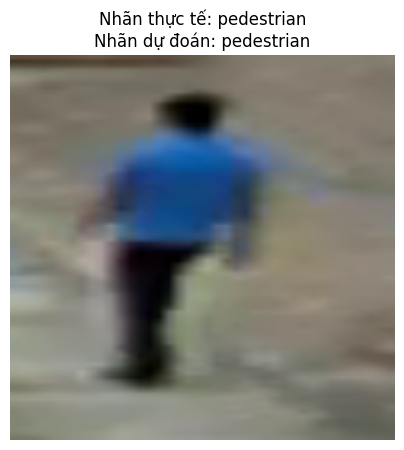

In [49]:
# Lấy một ảnh ngẫu nhiên từ tập test
import random
import numpy as np

# Giả sử X_test, y_test, và best_model (SVM tốt nhất) đã được tạo từ Cell 5 và Cell 6
if len(X_test) == 0:
    raise ValueError("Tập test rỗng. Vui lòng kiểm tra lại dữ liệu hoặc chạy lại các cell trước.")

# Chọn ngẫu nhiên một chỉ số từ tập test
test_idx = random.randint(0, len(X_test) - 1)
test_image = X_test[test_idx]
true_label = y_test[test_idx]

# Trích xuất descriptors SIFT cho ảnh test
test_descriptors = extract_sift_features([test_image])  # Đưa vào list để phù hợp với hàm

# Tạo đặc trưng BoW cho ảnh test với kích thước tốt nhất (giả sử 50)
best_bow_size = 200
test_features = create_features_bow(test_descriptors, bows[best_bow_size], best_bow_size)

# Dự đoán nhãn
predicted_label = best_model.predict(test_features)[0]

# Chuyển nhãn số thành nhãn chuỗi để dễ hiểu
id2label = {v: k for k, v in label2id.items()}
true_label_str = id2label[true_label]
predicted_label_str = id2label[predicted_label]

# In kết quả
print(f"Ảnh được chọn từ tập test (chỉ số {test_idx}):")
print(f"Nhãn thực tế: {true_label_str} (mã {true_label})")
print(f"Nhãn dự đoán: {predicted_label_str} (mã {predicted_label})")
print(f"Dự đoán {'đúng' if true_label == predicted_label else 'sai'}")

# Hiển thị ảnh (tùy chọn)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title(f"Nhãn thực tế: {true_label_str}\nNhãn dự đoán: {predicted_label_str}")
plt.axis('off')
plt.show()